In [1]:
# import libs
import keras 
from keras import layers
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

import csv
import matplotlib.pyplot  as plt
%matplotlib inline

import gc

Using TensorFlow backend.


In [2]:
print(tf.test.is_gpu_available())

True


In [3]:
#reading images into array
driving_log_dir = './sim_data/driving_log.csv'

images = []
measurements = []

with open(driving_log_dir) as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    for line in reader:
        center_image = plt.imread(line[0])
        left_image = plt.imread(line[1])
        right_image = plt.imread(line[2])
        images.extend([center_image, left_image, right_image])
        
        steer_center = float(line[3])
        steer_left = steer_center+0.2
        steer_right = steer_center-0.2
        measurements.extend([steer_center, steer_left, steer_right])
        
gc.collect()
        
images = np.array(images)
measurements = np.array(np.array(measurements))

In [4]:
#pring out the number of  images and steeting data
print(len(images), len(measurements))

22392 22392


In [5]:
#image shape
images[0].shape

(160, 320, 3)

In [6]:
#building model , the CNN part , cnn arch is useful in extacting the features of the camera images
model = keras.Sequential()

model.add(layers.Cropping2D(cropping=((60, 30), (0,0)), input_shape=(160,320,3)))
model.add(layers.Lambda(lambda x: (x/255.0)-0.5))

model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(128, (2,2), padding='same', activation='relu'))
model.add(layers.AveragePooling2D((2,2)))

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
#the last layer's output shape of CNN part
print(model.output_shape)

(None, 4, 20, 128)


In [8]:
#the sequence part , use lstm cell to fit the sequence infomations, because the driving condictions always base on some information happended few
#seconds ago, so I decided adding some sequence model 

model.add(layers.Reshape(target_shape=(4*20, 128)))
model.add(layers.LSTM(50, return_sequences=False, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(1))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
#model architecture summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 70, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 70, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 70, 320, 32)       896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 160, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 160, 64)       51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 80, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 80, 64)        102464    
__________

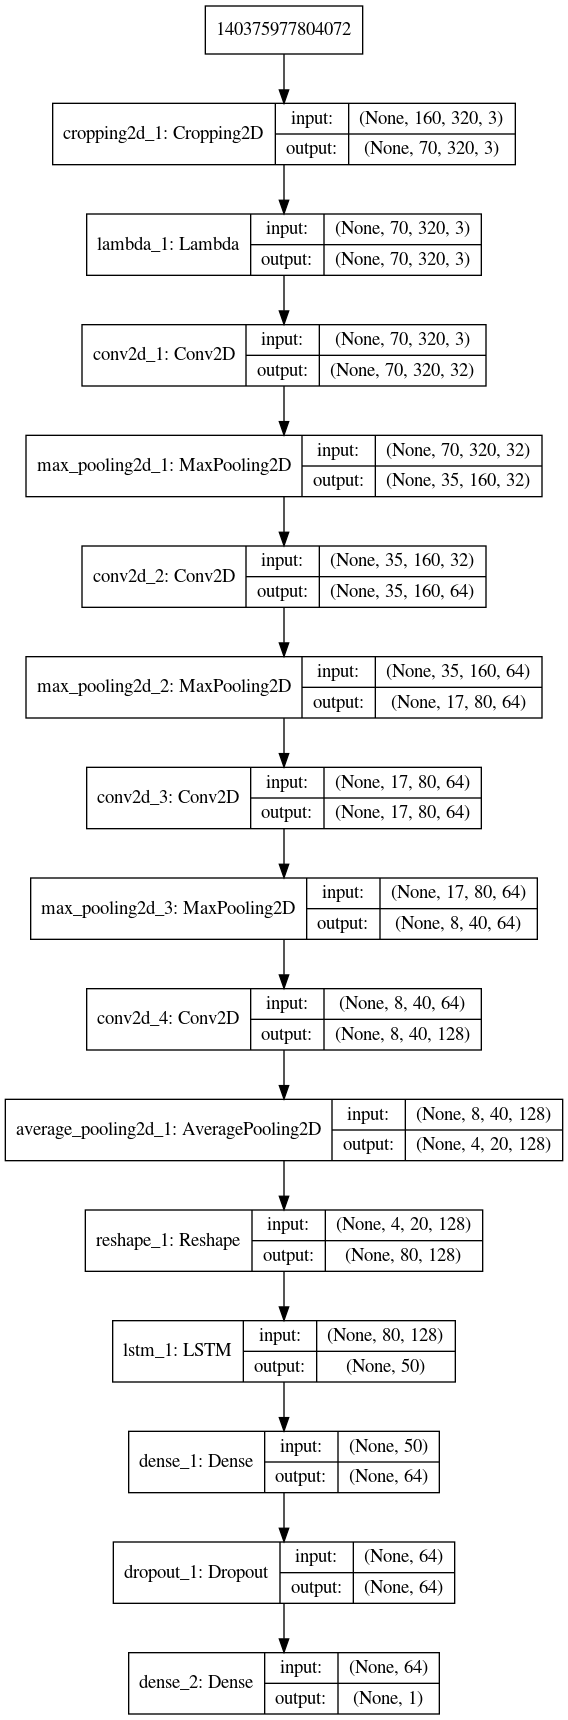

In [10]:
#model architecture
from IPython.display import Image
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True)

Image(retina=True, filename='model.png')

In [11]:
#compiling model with utils
model.compile(optimizer = keras.optimizers.Adam(0.0005),
                 loss='mse',
                 metrics=['mse'])

In [12]:
#training model
history = model.fit(images, measurements, 
                   batch_size=64, 
                   epochs=20, 
                   validation_split=0.2,
                   shuffle=False,
                   verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 17913 samples, validate on 4479 samples
Epoch 1/20
17913/17913 [==============================] - 71s 4ms/step - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0483 - val_mean_squared_error: 0.0483
Epoch 2/20
17913/17913 [==============================] - 49s 3ms/step - loss: 0.0922 - mean_squared_error: 0.0922 - val_loss: 0.0485 - val_mean_squared_error: 0.0485
Epoch 3/20
17913/17913 [==============================] - 49s 3ms/step - loss: 0.0330 - mean_squared_error: 0.0330 - val_loss: 0.0411 - val_mean_squared_error: 0.0411
Epoch 4/20
17913/17913 [==============================] - 49s 3ms/step - loss: 0.0294 - mean_squared_error: 0.0294 - val_loss: 0.0403 - val_mean_squared_error: 0.0403
Epoch 5/20
17913/17913 [==============================] - 49s 3ms/step - loss: 0.0281 - mean_squared_error: 0.0281 - val_loss: 0.0385 - val_mean_squared_error: 0.0385
Epoch 6/20
17913/17913 [==============================] - 49s 3ms/st

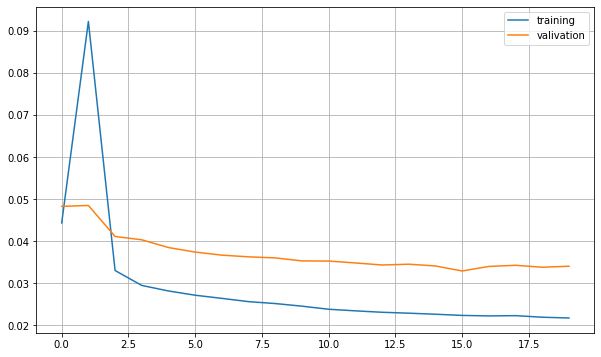

In [13]:
#plot training result
plt.figure(figsize=(10,6))
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.legend(['training', 'valivation'], loc='upper right')
plt.grid()
plt.show()

In [14]:
#save model
model.save('./model.h5')